In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam

from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

from keras import backend as K

2024-02-05 20:28:12.930606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
img_rows, img_cols = 28, 28

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images


In [7]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [8]:
#defining these prior to model to increase readability and debugging
batch_size = 64
epochs = 50

In [9]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                     input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [10]:
#Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

In [11]:
#Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                        

In [13]:
#for our case LearningRateScheduler will work great
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [14]:
#visualizing what the learning rate decay will do to the learning rate through every epoch
decays = [(lambda x: 1e-3 * 0.9 ** x)(x) for x in range(10)]
i=1

for lr in decays:
    print("Epoch " + str(i) +" Learning Rate: " + str(lr))
    i+=1

Epoch 1 Learning Rate: 0.001
Epoch 2 Learning Rate: 0.0009000000000000001
Epoch 3 Learning Rate: 0.0008100000000000001
Epoch 4 Learning Rate: 0.0007290000000000002
Epoch 5 Learning Rate: 0.0006561000000000001
Epoch 6 Learning Rate: 0.00059049
Epoch 7 Learning Rate: 0.000531441
Epoch 8 Learning Rate: 0.0004782969000000001
Epoch 9 Learning Rate: 0.0004304672100000001
Epoch 10 Learning Rate: 0.0003874204890000001


In [15]:
#by default this is evaluated on 'val_loss'
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [16]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=1, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr]) #left out early_stopping parameter as it gets better accuracy

/var/folders/pm/nz91x7pd21d1n869mrnq8s_00000gn/T/ipykernel_3173/3158446536.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs,


Epoch 1/50
937/937 [==============================] - 165s 173ms/step - loss: 0.2930 - accuracy: 0.9151 - val_loss: 0.0468 - val_accuracy: 0.9864 - lr: 0.0010
Epoch 2/50
937/937 [==============================] - 169s 181ms/step - loss: 0.1118 - accuracy: 0.9665 - val_loss: 0.0729 - val_accuracy: 0.9772 - lr: 9.0000e-04
Epoch 3/50
937/937 [==============================] - 161s 172ms/step - loss: 0.0854 - accuracy: 0.9751 - val_loss: 0.1077 - val_accuracy: 0.9665 - lr: 8.1000e-04
Epoch 4/50
937/937 [==============================] - 162s 172ms/step - loss: 0.0709 - accuracy: 0.9788 - val_loss: 0.0490 - val_accuracy: 0.9848 - lr: 7.2900e-04
Epoch 5/50
937/937 [==============================] - 170s 182ms/step - loss: 0.0613 - accuracy: 0.9816 - val_loss: 0.0269 - val_accuracy: 0.9918 - lr: 6.5610e-04
Epoch 6/50
937/937 [==============================] - 173s 184ms/step - loss: 0.0551 - accuracy: 0.9837 - val_loss: 0.0204 - val_accuracy: 0.9930 - lr: 5.9049e-04
Epoch 7/50
937/937 [======

In [17]:
import matplotlib.pyplot as plt

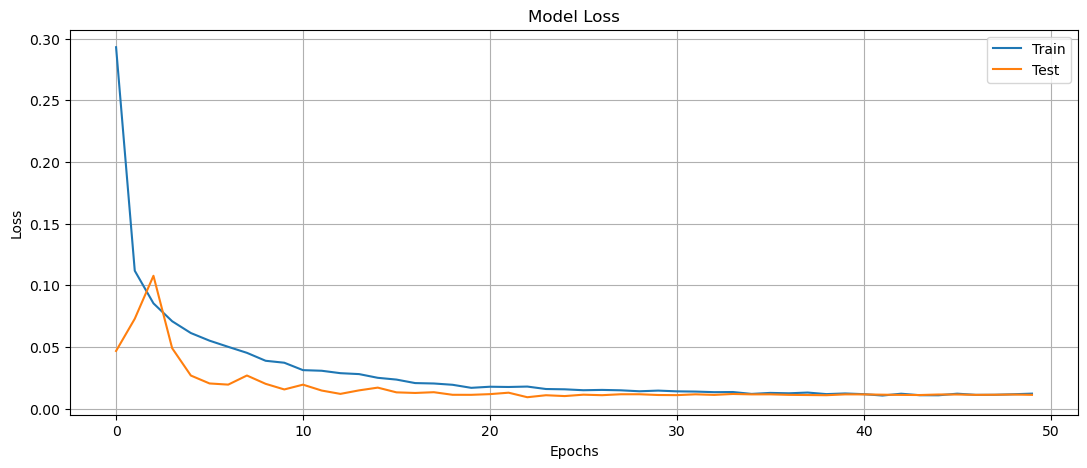

In [18]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

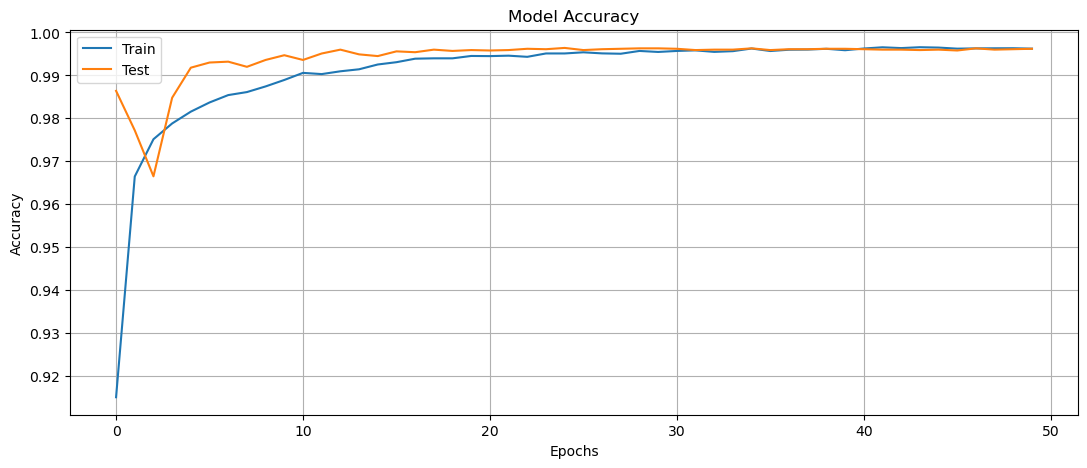

In [19]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

In [20]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.01120403315871954
Test accuracy: 0.9962000250816345


In [25]:
def predict_show_classes(model, x_test, y_test):
    # Get the predictions for the test data
    raw_predictions = model.predict(x_test)

    # Use numpy argmax to get the index of the maximum probability as the predicted class
    predicted_classes = np.argmax(raw_predictions, axis=1)

    # Get the indices to be plotted
    y_true = np.argmax(y_test, axis=1)
    correct = np.nonzero(predicted_classes == y_true)[0]
    incorrect = np.nonzero(predicted_classes != y_true)[0]

    print("Correct predicted classes:", correct.shape[0])
    print("Incorrect predicted classes:", incorrect.shape[0])

    target_names = ["Class {}:".format(i) for i in range(10)]
    print(classification_report(y_true, predicted_classes, target_names=target_names))

    return predicted_classes, correct, incorrect

In [26]:
predicted_classes, correct, incorrect = predict_show_classes(model, x_test, y_test)

313/313 [==============================] - 7s 21ms/step
Correct predicted classes: 9962
Incorrect predicted classes: 38
              precision    recall  f1-score   support

    Class 0:       1.00      1.00      1.00       980
    Class 1:       1.00      1.00      1.00      1135
    Class 2:       1.00      1.00      1.00      1032
    Class 3:       0.99      1.00      0.99      1010
    Class 4:       1.00      1.00      1.00       982
    Class 5:       1.00      0.99      1.00       892
    Class 6:       1.00      1.00      1.00       958
    Class 7:       1.00      1.00      1.00      1028
    Class 8:       1.00      1.00      1.00       974
    Class 9:       1.00      0.99      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [29]:
def plot_images(data_index, predicted_classes, cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(12,12))
    y_true = np.argmax(y_test,axis=1)
    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(x_test[indx].reshape(img_rows,img_cols), cmap=cmap)
        ax[i//4, i%4].axis('off')
        true_label = y_true[indx]
        pred_label = predicted_classes[indx]
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(y_true[indx],predicted_classes[indx]))
    plt.show() 

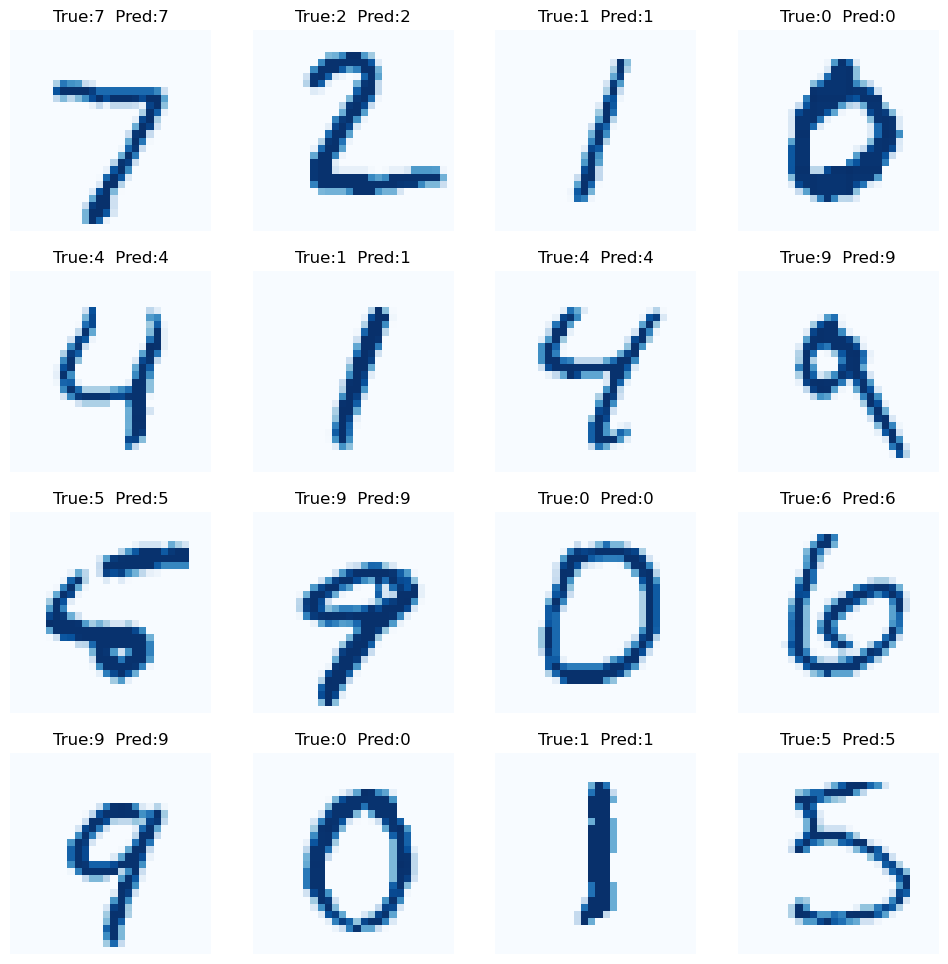

In [33]:
plot_images(correct, predicted_classes)

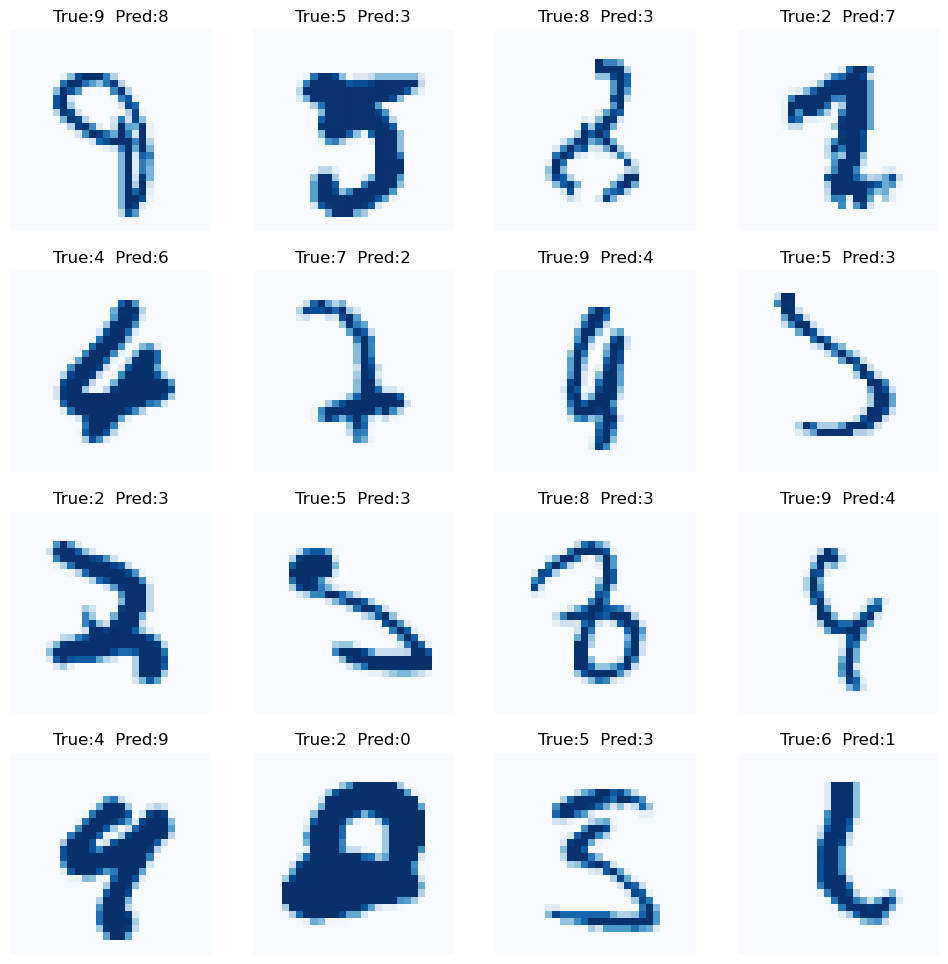

In [35]:
plot_images(incorrect, predicted_classes)